# Chapter 2 - Market Basket Analysis (Association Rule Mining)

Market basket analysis (MBA) is a technique used in data mining by retail companies to increase sales by better understanding customer buying patterns. It involves analyzing large datasets, such as customer purchase history, to uncover item groupings and products that are likely to be frequently purchased together.

In [1]:
#Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline
from mlxtend.frequent_patterns import apriori,association_rules
from collections import Counter
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
#read csv data
df = pd.read_csv('data/data.csv',encoding= 'unicode_escape')

#view first 5 rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Data Preparation

In [4]:
#null check
df.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [5]:
#Drop N/A
df1 = df.dropna()

df1.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
#selecting data where quantity > 0
df1 = df1[df1.Quantity > 0]

df1.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


### Insights from the dataset

#### Customers Insights

This segment will answer the questions like :

    1.Who all are my loyal customers?
    2.Which customers have ordered most frequently?
    3.Which customers contribute the most to my revenue?

In [7]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
# Creating a new feature 'Amount' which is the product of Quantity and its Unit Price
df1['Amount'] = df1['Quantity'] * df1['UnitPrice']

df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [9]:
# Using groupby function to highlight the Customers with most no. of orders (invoices)
orders = df1.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count()

print('The TOP 5 loyal customers with most number of orders...')
orders.sort_values(by='InvoiceNo', ascending=False).head()

The TOP 5 loyal customers with most number of orders...


,CustomerID,Country,InvoiceNo
4019,17841.0,United Kingdom,7847
1888,14911.0,EIRE,5677
1298,14096.0,United Kingdom,5111
334,12748.0,United Kingdom,4596
1670,14606.0,United Kingdom,2700


### Number of Orders by Different Customers

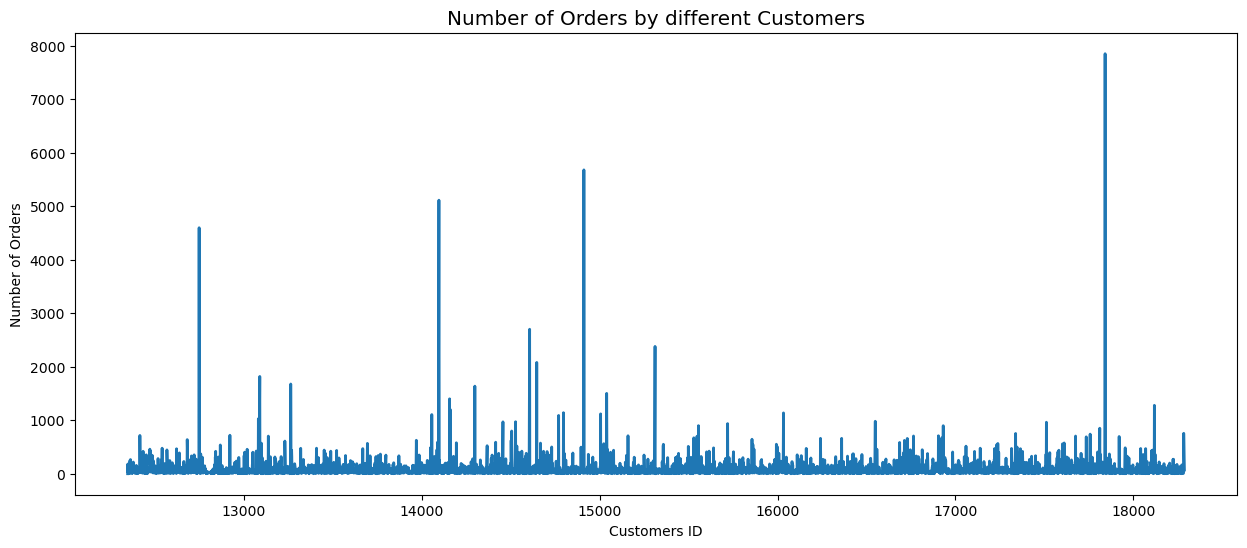

In [10]:
# Creating a subplot of size 15x6
plt.subplots(figsize=(15,6))

# Using the style bmh for better visualization
plt.style.use('bmh')

# X axis will denote the customer ID, Y axis will denote the number of orders
plt.plot(orders.CustomerID, orders.InvoiceNo)

# Labelling the X axis
plt.xlabel('Customers ID')

# Labelling the Y axis
plt.ylabel('Number of Orders')

# Giving a suitable title to the plot
plt.title('Number of Orders by different Customers')

plt.show()

In [11]:
# Using groupby function to highlight the Customers with highest spent amount (invoices)
money_spent = df1.groupby(by=['CustomerID','Country'], as_index=False)['Amount'].sum()

print('The TOP 5 profitable customers with highest money spent...')
money_spent.sort_values(by='Amount', ascending=False).head()

The TOP 5 profitable customers with highest money spent...


,CustomerID,Country,Amount
1698,14646.0,Netherlands,280206.02
4210,18102.0,United Kingdom,259657.30
3737,17450.0,United Kingdom,194550.79
3017,16446.0,United Kingdom,168472.50
1888,14911.0,EIRE,143825.06


### Money Spent by Different Customers

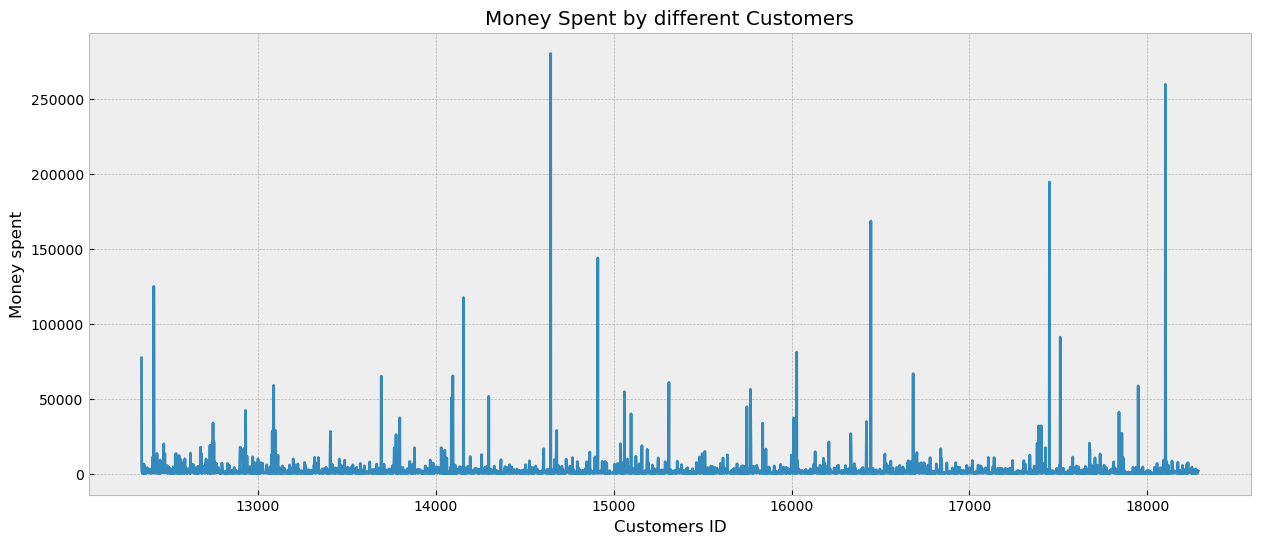

In [12]:
# Creating a subplot of size 15*6
plt.subplots(figsize=(15,6))

# X axis will denote the customer ID, Y axis will denote the amount spent
plt.plot(money_spent.CustomerID, money_spent.Amount)

# Using bmh style for better visualization
plt.style.use('bmh')

# Labelling the X-axis
plt.xlabel('Customers ID')

# Labelling the Y-axis
plt.ylabel('Money spent')

# Giving a suitable title to the plot
plt.title('Money Spent by different Customers')

plt.show()

### Patterns based on DateTime
This segment will answer the questions like:

    1.In which month, the number of orders placed is the highest?
    2.On which Day of a week, the number of orders placed is the highest?
    3.At what time of the day, the store is the busiest?

In [13]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [14]:
import datetime

# Convert InvoiceDate from object to datetime
df1['InvoiceDate'] = pd.to_datetime(df1.InvoiceDate, format='%m/%d/%Y %H:%M')

# Creating a new feature called year_month, such that December 2010 will be denoted as 201012
df1.insert(loc=2, column='year_month', value=df1['InvoiceDate'].map(lambda x: 100*x.year + x.month))

# Creating a new feature for Month
df1.insert(loc=3, column='month', value=df1.InvoiceDate.dt.month)

# Creating a new feature for Day
# +1 to make Monday=1.....until Sunday=7
df1.insert(loc=4, column='day', value=(df1.InvoiceDate.dt.dayofweek)+1)

# Creating a new feature for Hour
df1.insert(loc=5, column='hour', value=df1.InvoiceDate.dt.hour)

df1.head()

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,201012,12,3,8,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,201012,12,3,8,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,201012,12,3,8,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,201012,12,3,8,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,201012,12,3,8,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### How many orders are placed per month?

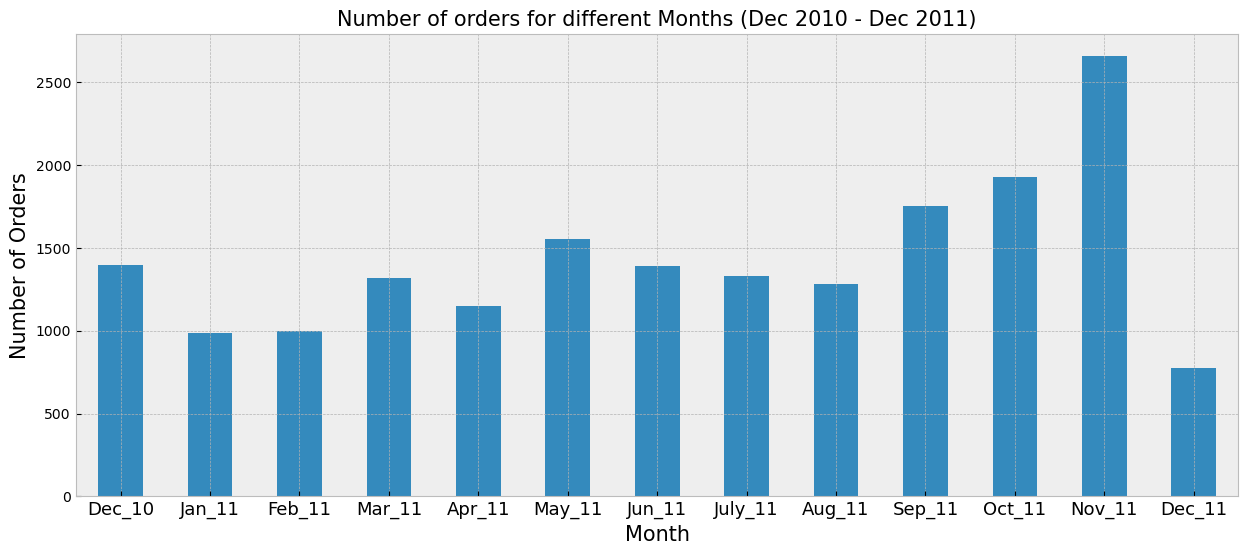

In [15]:
# Using bmh style for better visualization
plt.style.use('bmh')

# Using groupby to extract No. of Invoices year-monthwise
ax = df1.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))

# Labelling the X axis
ax.set_xlabel('Month',fontsize=15)

# Labelling the Y-axis
ax.set_ylabel('Number of Orders',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Number of orders for different Months (Dec 2010 - Dec 2011)',fontsize=15)

# Providing with X tick labels
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), 
                   rotation='horizontal', fontsize=13)

plt.show()

### How many orders are placed per Day?

In [16]:
# Day = 6 is Saturday and there are no orders placed on Saturdays
df1[df1['day']==6]

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount


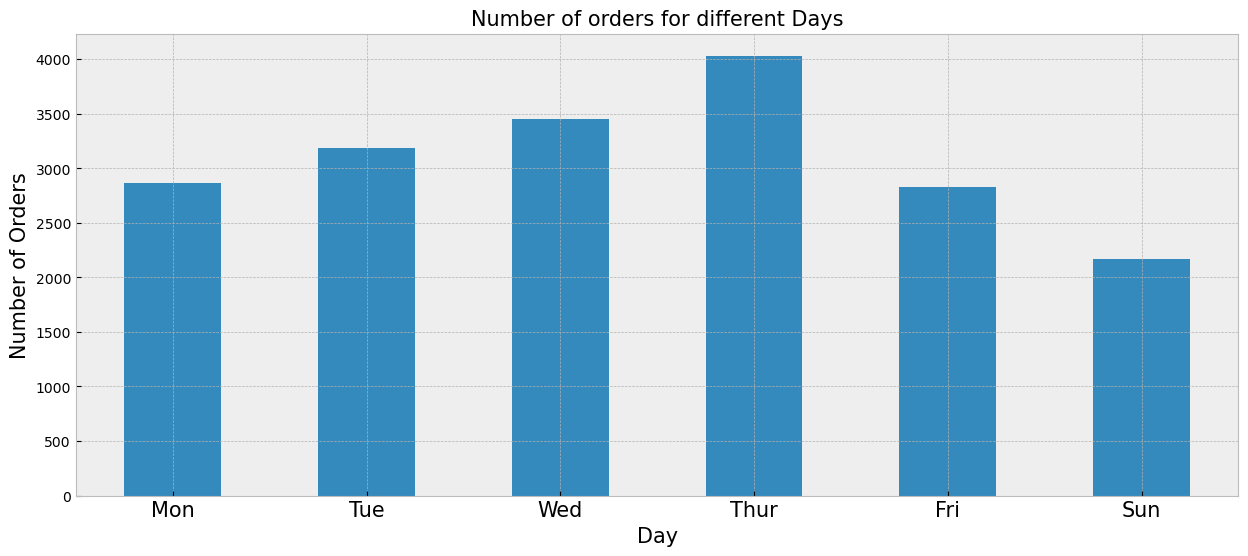

In [17]:
# Using groupby to count no. of Invoices daywise
ax = df1.groupby('InvoiceNo')['day'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))

# Labelling X axis
ax.set_xlabel('Day',fontsize=15)

# Labelling Y axis
ax.set_ylabel('Number of Orders',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Number of orders for different Days',fontsize=15)

# Providing with X tick labels
# Since there are no orders placed on Saturdays, we are excluding Sat from xticklabels
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)

plt.show()

### How many orders are placed per Hour?

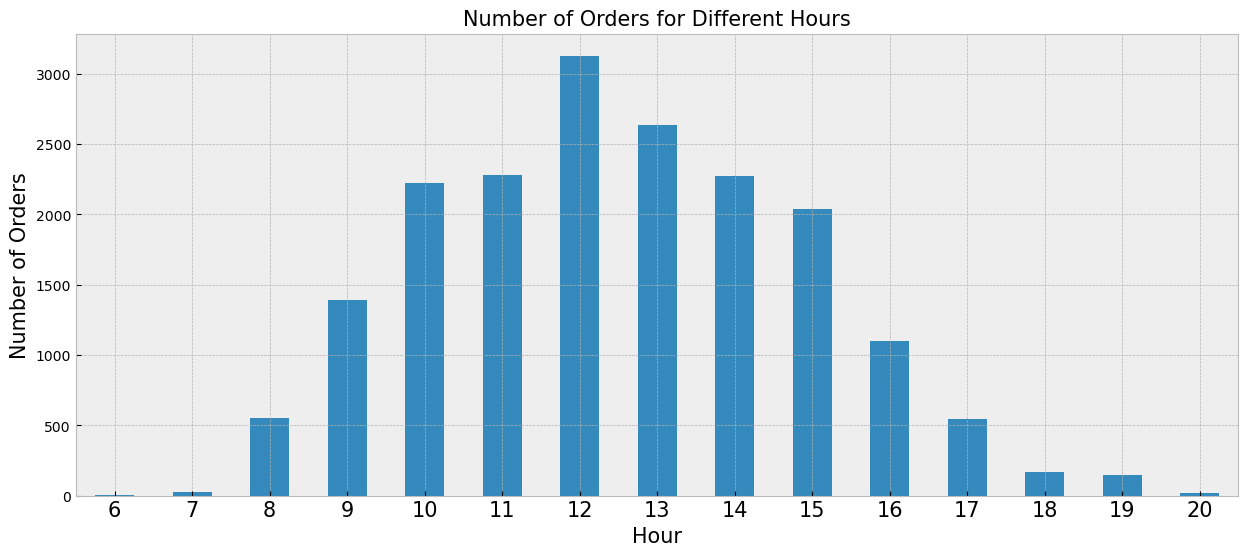

In [18]:
# Using groupby to get unique hours for each invoice, then explode to individual hours
hours = df1.groupby('InvoiceNo')['hour'].unique().explode()

# Count the number of occurrences of each hour
hour_counts = hours.value_counts().sort_index()

# Plot the results
ax = hour_counts.plot(kind='bar', figsize=(15, 6))

# Labeling X axis
ax.set_xlabel('Hour', fontsize=15)

# Labeling Y axis
ax.set_ylabel('Number of Orders', fontsize=15)

# Giving a suitable title to the plot
ax.set_title('Number of Orders for Different Hours', fontsize=15)

# Providing with X tick labels (all orders are placed between 6 and 20 hour)
ax.set_xticklabels(range(6, 21), rotation='horizontal', fontsize=15)

plt.show()

### Free Items and Sales

This segment will display how FREE items impact the No. of Orders. This answers how will the discounts and offers impact my sale?

In [19]:
df1.UnitPrice.describe()

count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

Since the minimum unit price = 0, there are either incorrect entries or free items.

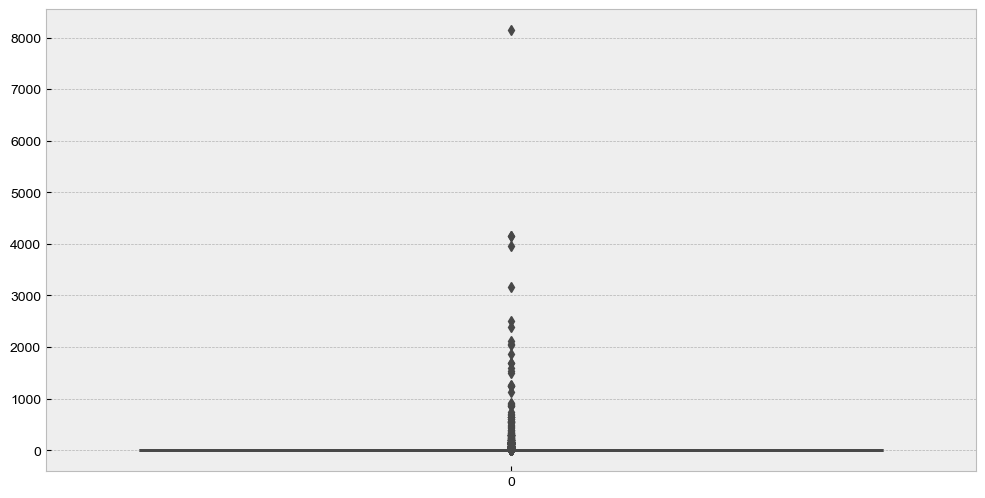

In [20]:
# checking the distribution of unit price
plt.subplots(figsize=(12,6))

# Using darkgrid style for better visualization
sns.set_style('darkgrid')

# Applying boxplot visualization on Unit Price
sns.boxplot(df1.UnitPrice)

plt.show()

Let's improve it!

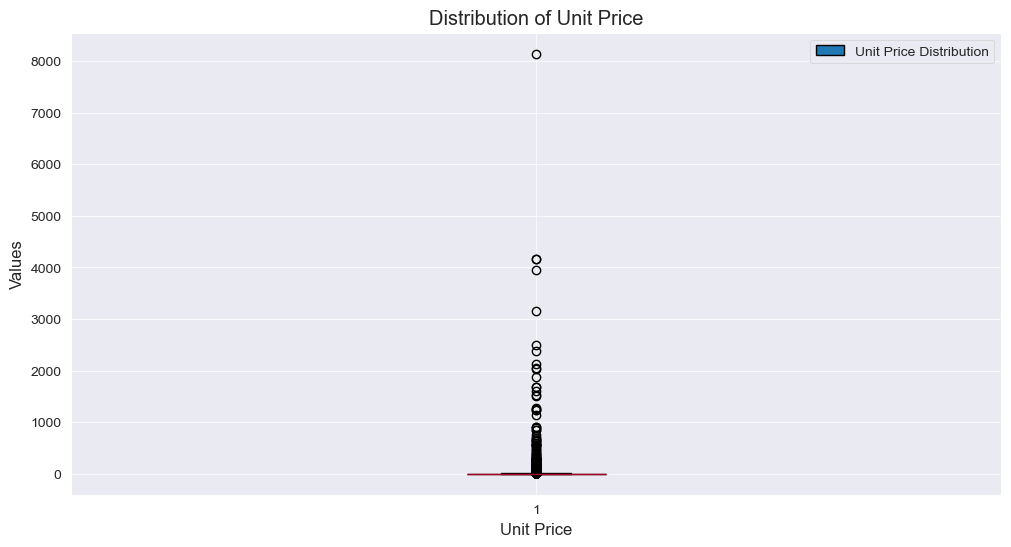

In [21]:
# checking the distribution of unit price
plt.subplots(figsize=(12,6))

# Using darkgrid style for better visualization
sns.set_style('darkgrid')

# Applying boxplot visualization on Unit Price
box = plt.boxplot(df1['UnitPrice'], patch_artist=True)

# Adding colors and legend
colors = ['#1f77b4']  # You can choose any color you like
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Adding a legend
plt.legend([box["boxes"][0]], ['Unit Price Distribution'], loc='upper right')

# Adding labels and title
plt.xlabel('Unit Price')
plt.ylabel('Values')
plt.title('Distribution of Unit Price')

# Display the plot
plt.show()

Items with UnitPrice = 0 are not outliers. These are the “free” items.

In [22]:
# Creating a new df of free items
free_items = df1[df1['UnitPrice'] == 0]
free_items.head()

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
9302,537197,22841,201012,12,7,14,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,0.0
33576,539263,22580,201012,12,4,14,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,0.0
40089,539722,22423,201012,12,2,13,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,0.0
47068,540372,22090,201101,1,4,16,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0.0
47070,540372,22553,201101,1,4,16,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0.0


In [23]:
# Counting how many free items were given out year-month wise
free_items.year_month.value_counts().sort_index()

year_month
201012     3
201101     3
201102     1
201103     2
201104     2
201105     2
201107     2
201108     6
201109     2
201110     3
201111    14
Name: count, dtype: int64

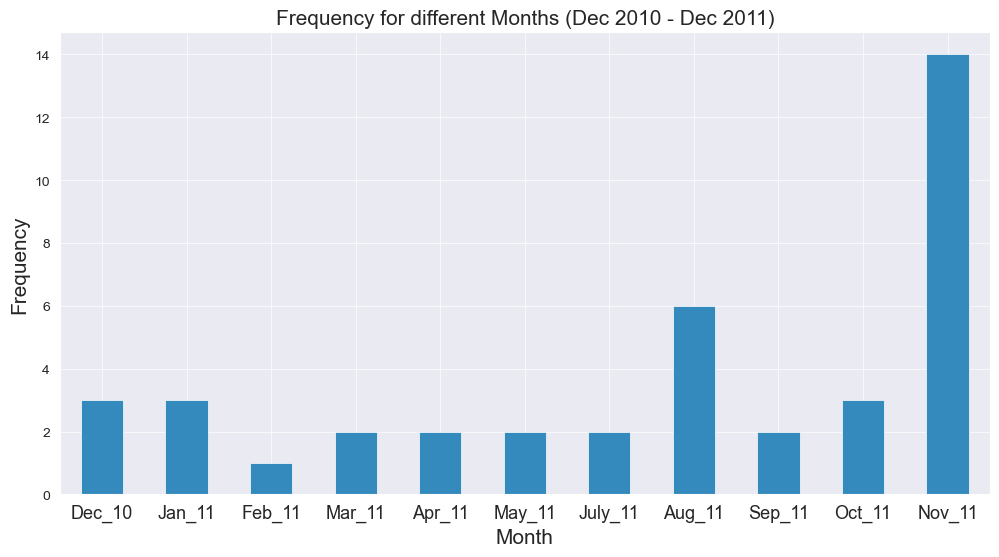

In [24]:
# Counting how many free items were given out year-month wise
ax = free_items.year_month.value_counts().sort_index().plot(kind='bar',figsize=(12,6))

# Labelling X-axis
ax.set_xlabel('Month',fontsize=15)

# Labelling Y-axis
ax.set_ylabel('Frequency',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Frequency for different Months (Dec 2010 - Dec 2011)',fontsize=15)

# Providing X tick labels
# Since there are 0 free items in June 2011, we are excluding it
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11'), rotation='horizontal', 
                   fontsize=13)
plt.show()

The most no. of free items were given out in November 2011. Also, the most no. of orders were placed in November 2011 as seen below :

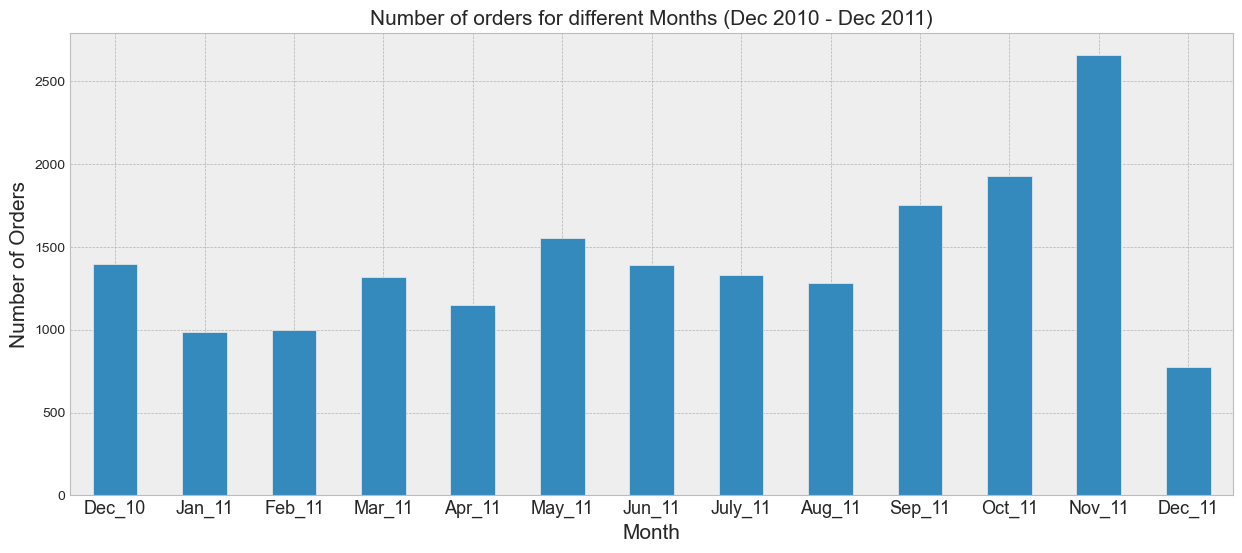

In [25]:
plt.style.use('bmh')

# Using groupby to count unique no. of Invoices year-month wise
ax = df1.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))

# Labelling X axis
ax.set_xlabel('Month',fontsize=15)

# Labelling Y axis
ax.set_ylabel('Number of Orders',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Number of orders for different Months (Dec 2010 - Dec 2011)',fontsize=15)

# Providing with X tick labels
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), 
                   rotation='horizontal', fontsize=13)

plt.show()

Also, compared to May, sales declined which means there was a slight effect of NO FREE ITEMS on the number of orders.

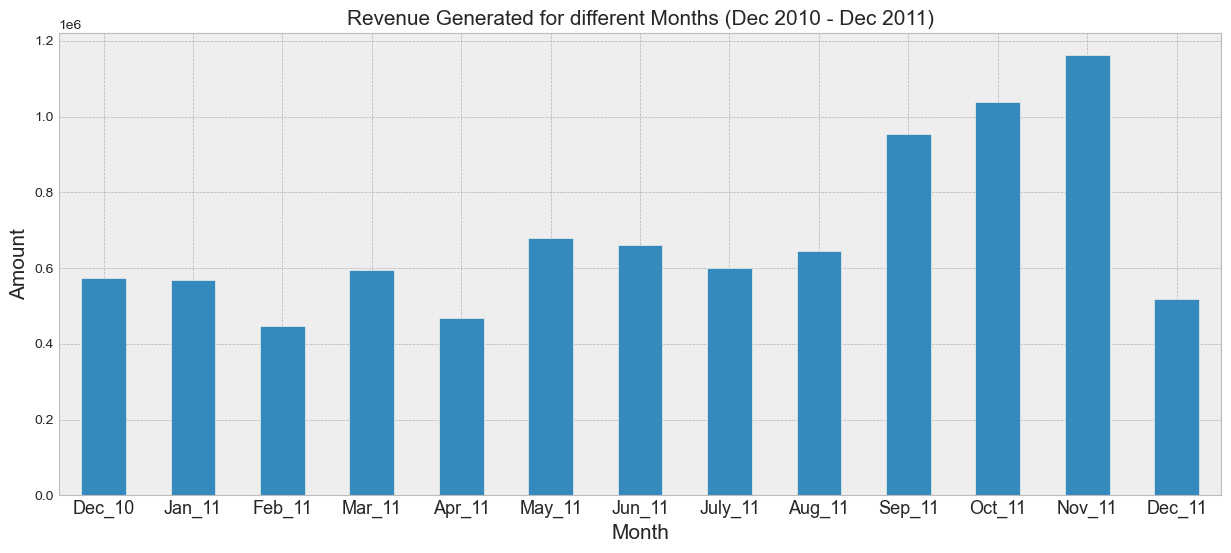

In [26]:
plt.style.use('bmh')

# Using groupby to sum the amount spent year-month wise
ax = df1.groupby('year_month')['Amount'].sum().sort_index().plot(kind='bar',figsize=(15,6))

# Labelling X axis
ax.set_xlabel('Month',fontsize=15)

# Labelling Y axis
ax.set_ylabel('Amount',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Revenue Generated for different Months (Dec 2010 - Dec 2011)',fontsize=15)

# Providing with X tick labels
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), 
                   rotation='horizontal', fontsize=13)

plt.show()

### Items Insights
This segment will answer the questions like :

    1.Which item is bought by most no. of customers?
    2.Which is the most sold item based on sum of sales?
    3.Which is the most sold item based on the count of orders?
    4.Which items are the first choice items for most no. of invoices?

### Most sold item based on Quantity

In [27]:
df1.head()

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,201012,12,3,8,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,201012,12,3,8,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,201012,12,3,8,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,201012,12,3,8,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,201012,12,3,8,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [28]:
# Creating a new pivot table which sums the Quantity ordered for each item
most_sold_items = df1.pivot_table(index=['StockCode','Description'], values='Quantity', aggfunc='sum').sort_values(by='Quantity', ascending=False)

most_sold_items.head()

,,Quantity
StockCode,Description,
23843,"PAPER CRAFT , LITTLE BIRDIE",80995
23166,MEDIUM CERAMIC TOP STORAGE JAR,77916
84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415
85099B,JUMBO BAG RED RETROSPOT,46181
85123A,WHITE HANGING HEART T-LIGHT HOLDER,36725


Text(0, 0.5, 'Item')

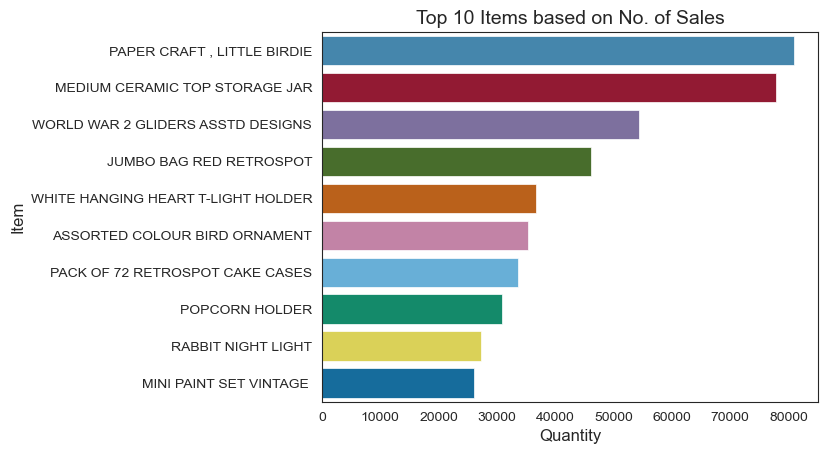

In [29]:
most_sold_items.reset_index(inplace=True)
sns.set_style('white')

# Creating a bar plot of Description ( or the item ) on the Y axis and the sum of Quantity on the X axis
# We are plotting only the 10 most ordered items
sns.barplot(y='Description', x='Quantity', data=most_sold_items.head(10))

# Giving suitable title to the plot
plt.title('Top 10 Items based on No. of Sales', fontsize=14)

plt.ylabel('Item')

### Items bought by most no. of Customers

In [30]:
# choosing WHITE HANGING HEART T-LIGHT HOLDER as a sample
df_white = df1[df1['Description']=='WHITE HANGING HEART T-LIGHT HOLDER']

# This denotes that WHITE HANGING HEART T-LIGHT HOLDER has been ordered 2028 times
df_white.shape

(2028, 13)

In [31]:
# This denotes that WHITE HANGING HEART T-LIGHT HOLDER has been ordered by 856 customers
len(df_white.CustomerID.unique())

856

In [32]:
# Creating a pivot table that displays the sum of unique Customers who bought particular item
bought_by_most_customers = df1.pivot_table(index=['StockCode','Description'], values='CustomerID', 
                                           aggfunc=lambda x: len(x.unique())).sort_values(by='CustomerID', ascending=False)

bought_by_most_customers

,,CustomerID
StockCode,Description,
22423,REGENCY CAKESTAND 3 TIER,881
85123A,WHITE HANGING HEART T-LIGHT HOLDER,856
47566,PARTY BUNTING,708
84879,ASSORTED COLOUR BIRD ORNAMENT,678
22720,SET OF 3 CAKE TINS PANTRY DESIGN,640
...,...,...
21897,POTTING SHED CANDLE CITRONELLA,1
84795C,OCEAN STRIPE HAMMOCK,1
90125E,AMBER BERTIE GLASS BEAD BAG CHARM,1


Text(0, 0.5, 'Item')

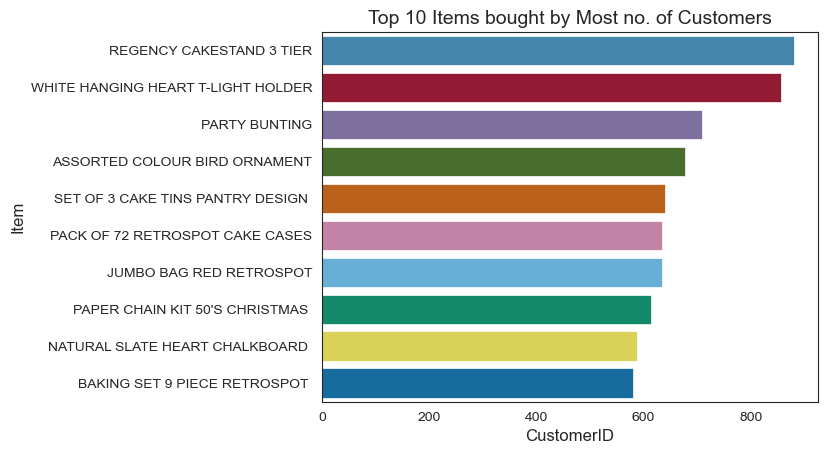

In [33]:
bought_by_most_customers.reset_index(inplace=True)
sns.set_style('white')

# Creating a bar plot of Description ( or the item ) on the Y axis and the sum of unique Customers on the X axis
# We are plotting only the 10 most bought items
sns.barplot(y='Description', x='CustomerID', data=bought_by_most_customers.head(10))

# Giving suitable title to the plot
plt.title('Top 10 Items bought by Most no. of Customers', fontsize=14)

plt.ylabel('Item')

### Most Frequently Ordered Items

In [34]:
# Preparing data for wordcloud
df1['items'] = df1['Description'].str.replace(' ', '_')

df1.head()

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,items
0,536365,85123A,201012,12,3,8,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,WHITE_HANGING_HEART_T-LIGHT_HOLDER
1,536365,71053,201012,12,3,8,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,WHITE_METAL_LANTERN
2,536365,84406B,201012,12,3,8,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,CREAM_CUPID_HEARTS_COAT_HANGER
3,536365,84029G,201012,12,3,8,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,KNITTED_UNION_FLAG_HOT_WATER_BOTTLE
4,536365,84029E,201012,12,3,8,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,RED_WOOLLY_HOTTIE_WHITE_HEART.


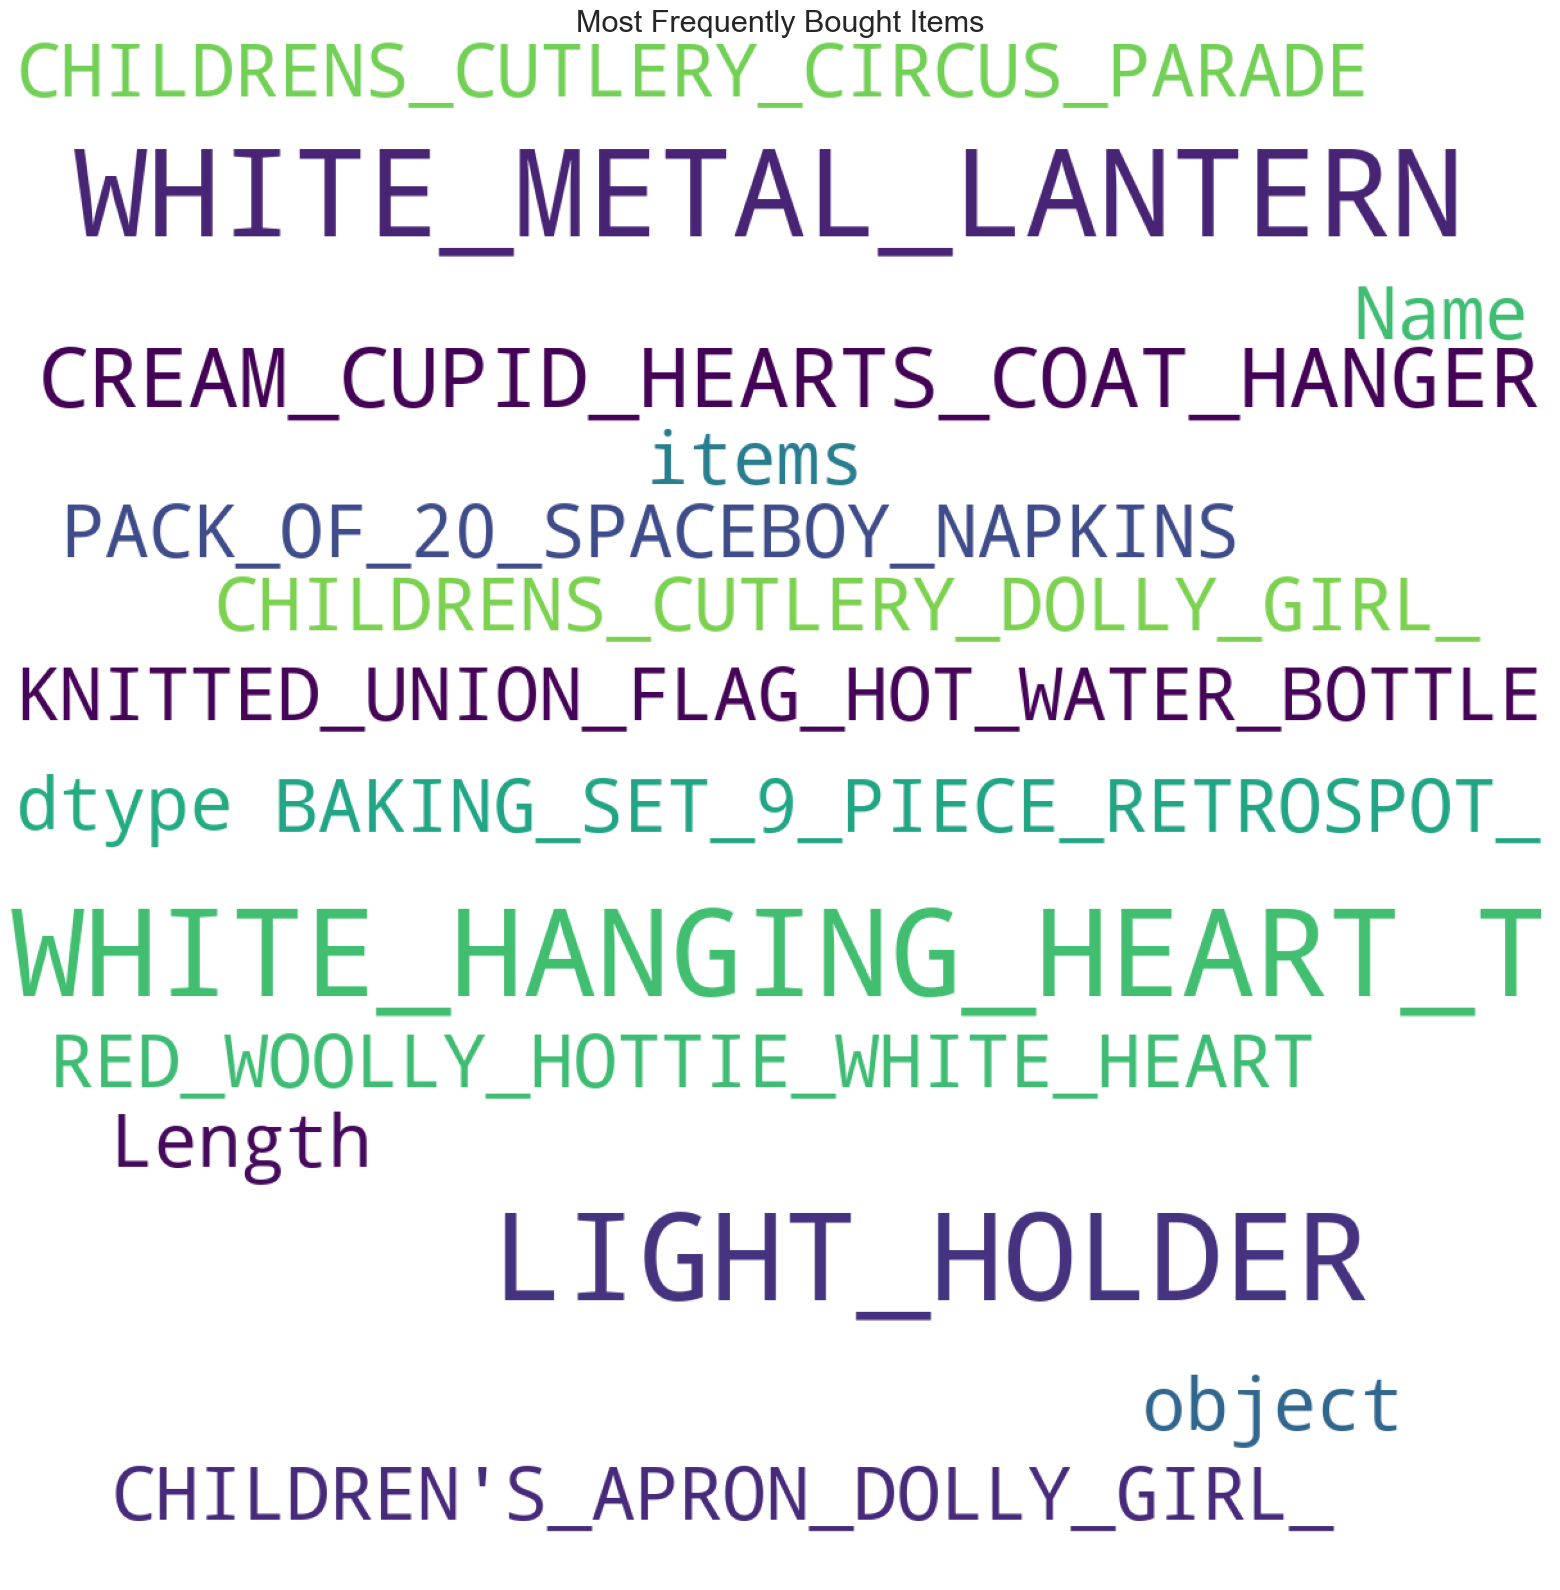

In [35]:
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (20, 20)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(df1['items']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Frequently Bought Items',fontsize = 22)
plt.show()

### Top 10 First Choices

In [36]:
# Storing all the invoice numbers into a list y
y = df1['InvoiceNo']
y = y.to_list()

# Length of y
len(y)

397924

In [37]:
# Using set function to find unique invoice numbers only and storing them in invoices list
invoices = list(set(y))

# Lenght of invoices ( or count of unique invoice numbers )
len(invoices)

18536

In [38]:
# Creating empty list first_choices
first_choices = []

# looping into list of unique invoice numbers
for i in invoices:
    
    # the first item (index = 0) of every invoice is the first purchase
    # extracting the item name for the first purchase
    first_purchase = df1[df1['InvoiceNo']==i]['items'].reset_index(drop=True)[0]
    
    # Appending the first purchase name into first choices list
    first_choices.append(first_purchase)

# First 5 elements
first_choices[:5]

['SET_OF_4_PANTRY_JELLY_MOULDS',
 '3_PIECE_SPACEBOY_COOKIE_CUTTER_SET',
 'RED_RETROSPOT_CHILDRENS_UMBRELLA',
 'GRAND_CHOCOLATECANDLE',
 'WHITE_HANGING_HEART_T-LIGHT_HOLDER']

In [39]:
# Length of first_choices mathches the lenght of invoices
len(first_choices)

18536

In [43]:
# Using counter to count repeating first choices
count = Counter(first_choices)

# Storing the counter into a datafrane
df_first_choices = pd.DataFrame.from_dict(count, orient='index').reset_index()

# Rename columns as item and count
df_first_choices.rename(columns={'index':'item', 0:'count'},inplace=True)

# Sorting the df based on count
df_first_choices.sort_values(by='count',ascending=False)

df_first_choices

,item,count
0,SET_OF_4_PANTRY_JELLY_MOULDS,51
1,3_PIECE_SPACEBOY_COOKIE_CUTTER_SET,8
2,RED_RETROSPOT_CHILDRENS_UMBRELLA,9
3,GRAND_CHOCOLATECANDLE,19
4,WHITE_HANGING_HEART_T-LIGHT_HOLDER,181
...,...,...
2630,S/4_GROOVY_CAT_MAGNETS,1
2631,RED_KUKUI_COCONUT_SEED_NECKLACE,1
2632,SCOTTIES_DESIGN_WASHBAG,1
2633,MONEY_BOX_BISCUITS_DESIGN,1


Text(0, 0.5, 'Item')

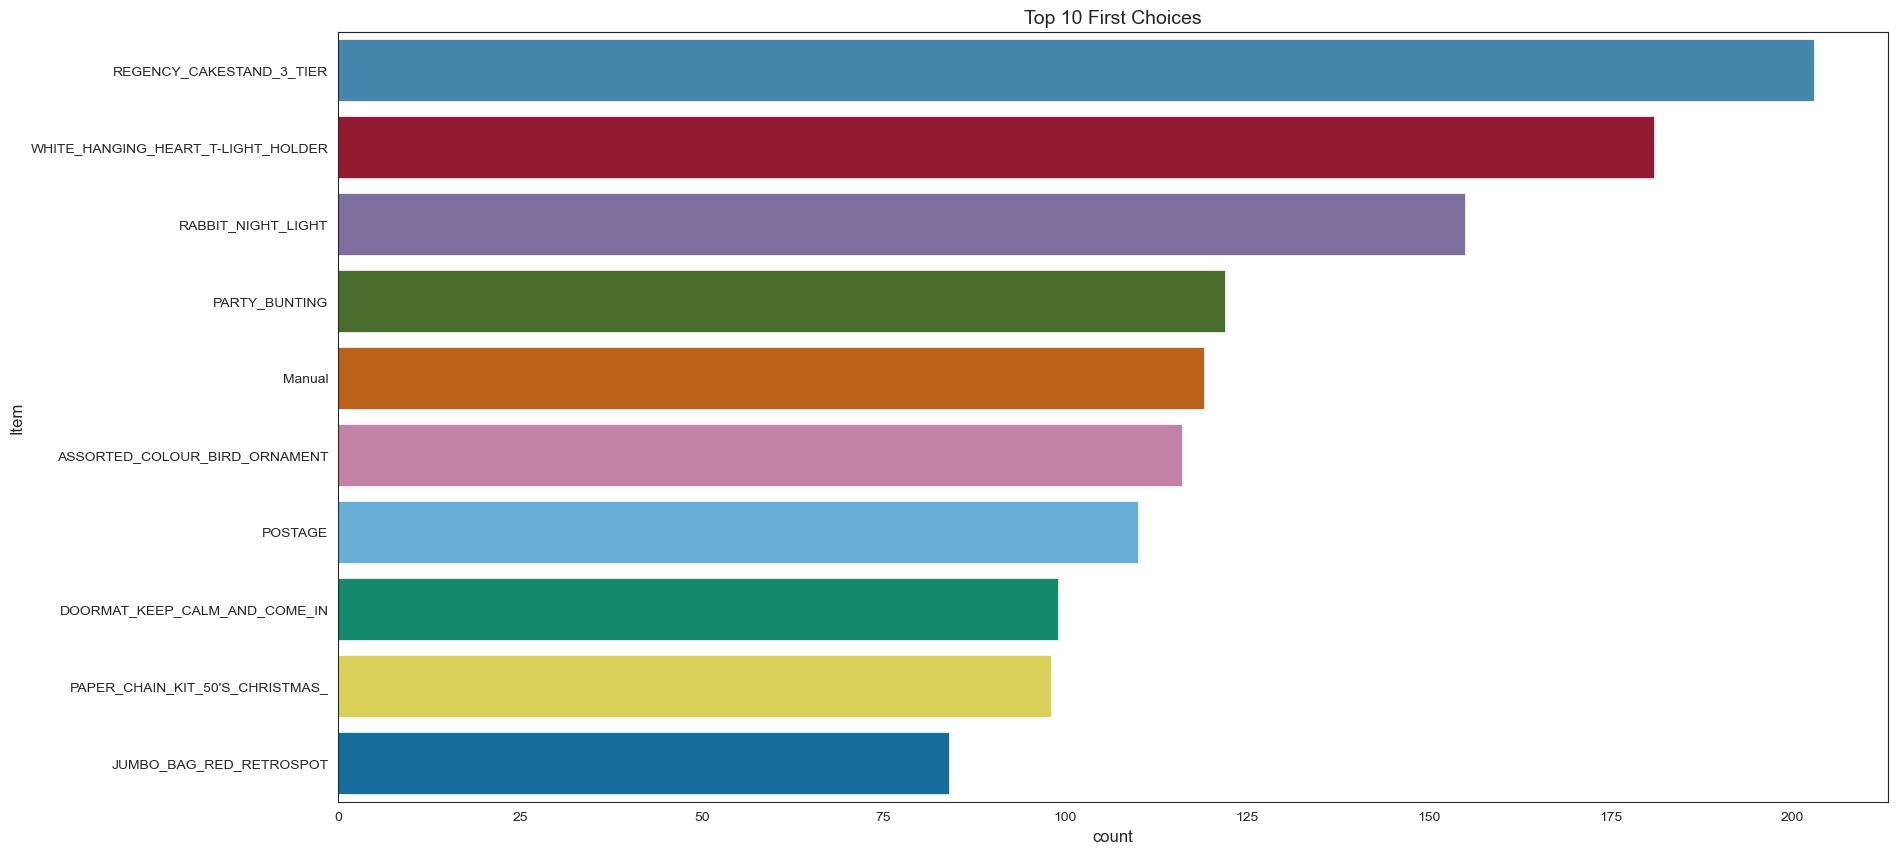

In [44]:
plt.subplots(figsize=(20,10))
sns.set_style('white')

# Creating a bar plot that displays Item name on the Y axis and Count on the X axis
sns.barplot(y='item', x='count', data=df_first_choices.sort_values(by='count',ascending=False).head(10))

# Giving suitable title to the plot
plt.title('Top 10 First Choices', fontsize=14)

plt.ylabel('Item')

### Frequently Bought Together

Market basket analysis is a data mining technique used by retailers to increase sales by better understanding customer purchasing patterns. It involves analyzing large data sets, such as purchase history, to reveal product groupings, as well as products that are likely to be purchased together.

This segment will answer the questions like:

1. Which items are frequently bought together?
2. If a user buys an item X, which item is he/she likely to buy next?

In [45]:
# Using groupby function to create a basket df, which specifies if an item is present in a particular invoiceno
# for all items and all invoices. This will denote the quantity present in the particular invoiceno which needs to be fixed

basket = (df1.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))

basket.head(10)

This output gets the quantity ordered (e.g., 48,24,126), but we just want to know if an item was purchased or not. So, let’s encode the units as 1 (if purchased) or 0 (not purchased).

In [47]:
# Encoding units as 1(if purchased) or 0(not purchased)

def encode_units(x):
    if x < 1:
        return 0
    if x >= 1:
        return 1

basket = basket.applymap(encode_units)

basket.head(10)

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# Let's see how many 0's & 1's
counts = pd.Series(basket.values.ravel()).value_counts()

print(counts)

0    71476300
1      387772
Name: count, dtype: int64


### Apriori Algorithm Concepts
What is Support, Confidence and Lift?

<div style="text-align:center;">
    <img src='images/Support_Explanation.jpg' width='600'>
</div>

Example : If out of 100 users, 10 purchase Milk then **support for Milk** will be 10/100 = 10% The formula for calculation is as given below :

<div style="text-align:center;">
    <img src='images/Support_Formula.jpg' width='600'>
</div>

<div style="text-align:center;">
    <img src='images/Confidence_Explanation.jpg' width='600'>
</div>

Suppose you are looking to build a relationship between milk and bread. If 7 out of 40 milk buyers also buy bread, then **confidence** = 7/40 = 17.5%

The formula to calculate confidence is as given below :

<div style="text-align:center;">
    <img src='images/Confidence_Formula.jpg' width='600'>
</div>

<div style="text-align:center;">
    <img src='images/Lift.jpg' width='600'>
</div>

$$ Lift = Confidence/Support $$

$$ Lift = 17.5/10 = 1.75 $$

## Association Rules

Association rule mining finds interesting associations and relationships among large sets of data items. This rule shows how frequently a itemset occurs in a transaction. Based on those rules created from the Dataset, we perform Market Basket Analysis.